# SIR model

----


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Collect-cases-script" data-toc-modified-id="Collect-cases-script-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>Collect cases script</a></span></li><li><span><a href="#Check-treatment" data-toc-modified-id="Check-treatment-0.0.2"><span class="toc-item-num">0.0.2&nbsp;&nbsp;</span>Check treatment</a></span></li></ul></li><li><span><a href="#import-data" data-toc-modified-id="import-data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>import data</a></span></li><li><span><a href="#Testing-new-cases-dataset:-https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv" data-toc-modified-id="Testing-new-cases-dataset:-https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Testing new cases dataset: <a href="https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv" target="_blank">https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv</a></a></span></li><li><span><a href="#define-parametes" data-toc-modified-id="define-parametes-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>define parametes</a></span></li><li><span><a href="#run-model-function" data-toc-modified-id="run-model-function-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>run model function</a></span></li><li><span><a href="#plot-city" data-toc-modified-id="plot-city-0.5"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>plot city</a></span></li></ul></li><li><span><a href="#MODELO" data-toc-modified-id="MODELO-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MODELO</a></span></li></ul></div>

#### Collect cases script

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from paths import *
import numpy as np
import plotly.express as px
import yaml
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as md


sorted(TREAT_PATH.glob('*.csv'))

[PosixPath('/Users/joaoc/Documents/projects/SimulaCorona/data/treated/treated_covid19_SUS_database.csv'),
 PosixPath('/Users/joaoc/Documents/projects/SimulaCorona/data/treated/treated_covid19_cases.csv')]

### import data

### Testing new cases dataset: https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv

In [43]:
def normalize_cols(df):
    return pd.Series(df).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()

def get_sus_data(path):
    
    df_sus = pd.read_csv(path)
    cols = ['region_id', 'municipio', 'uf', 'populacao', 'quantidade_leitos']
    df_sus = df_sus[cols].fillna(0)

    # remove apostoflo
    df_sus['municipio'] = df_sus['municipio'].str.replace('\'', '')
    df_sus['region_id'] = df_sus['region_id'].str.replace('\'', '')

    # get the information for states
    df_states = df_sus.groupby(by='uf', as_index=False).sum()
    df_states['municipio'] = df_states['uf']
    df_states['region_id'] = df_states['uf']

    # # put states in same order as df_sus
    cols = df_sus.columns
    df_states = df_states[cols]

    # concat states information with sus information
    df_sus = pd.concat([df_states,df_sus],axis=0)
    
    return df_sus

def import_cities(path):
    
    df_cases2 = pd.read_csv(path)
    df_cases2 = df_cases2.sort_values(by='date', ascending=False)

    df_cases2 = df_cases2.rename({'totalCases': 'confirmed', 'newCases': 'new_confirmed'}, axis=1)
    df_cases2 = df_cases2[df_cases2['state'] != 'TOTAL']

    df_cases2['region_id'] = df_cases2['city'].str.replace('/', ' ')

    df_cases2['region_id'] = normalize_cols(df_cases2['region_id'])

    df_cases2['place_type'] = 'city'
    
    # get only last day data for each city
    df_cases2 = df_cases2.drop_duplicates(subset=['city'], keep='first')
    df_cases2 = df_cases2.sort_values(by='confirmed', ascending=False)

    cols = ['region_id', 'city', 'place_type', 'date', 'confirmed']
    
    return df_cases2[cols]
    

### run model function

In [44]:
from models import sir

In [45]:
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)

In [46]:
df_cases = import_cities(config['data_paths']['cases'])

df_sus = get_sus_data(TREAT_PATH / config['data_paths']['sus'])

# merge sus and cases data
df = pd.merge(df_cases, df_sus, how='left', on='region_id')

In [48]:
df_final = pd.DataFrame()

for region_id in df['region_id'].unique():
    for scenario, s_values  in config['scenarios'].items():
        for bound, r0 in s_values['R0'].items():
            
            df_city = df.query(f"municipio_uf == '{region_id}'")

            current_state = {
                'population': df_city['populacao'].values[0],
                'current_infected': df_city['confirmed'].values[0]
            }

            config['model_parameters']['sir']['R0'] = r0

            res = sir.entrypoint(current_state, config['model_parameters']['sir'])
            
            res['region_id'] = region_id
            res['scenario'] = scenario
            res['bound'] = bound
            
            df_final = pd.concat([df_final, res], axis=0)

#     df_final.to_csv(OUTPUT_PATH / 'model_for_city_{}.csv'.format(study), index=False)
        
# df_final.to_csv('../data/output/model_for_city.csv', index=False)

UndefinedVariableError: name 'municipio_uf' is not defined

In [20]:
df_final

,S,R,I,I2,I3,I1,city,scenario,bound
0,1.225166e+07,366.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,São Paulo,nothing,lower_bound
1,1.225159e+07,404.601501,2.573573e+01,3.860359,1.286786,2.058858e+01,São Paulo,nothing,lower_bound
2,1.225152e+07,447.273835,5.418575e+01,8.127863,2.709288,4.334860e+01,São Paulo,nothing,lower_bound
3,1.225144e+07,494.446211,8.563632e+01,12.845448,4.281816,6.850905e+01,São Paulo,nothing,lower_bound
4,1.225136e+07,546.593077,1.204038e+02,18.060577,6.020192,9.632308e+01,São Paulo,nothing,lower_bound
5,1.225126e+07,604.238863,1.588381e+02,23.825716,7.941905,1.270705e+02,São Paulo,nothing,lower_bound
6,1.225115e+07,667.963274,2.013258e+02,30.198865,10.066288,1.610606e+02,São Paulo,nothing,lower_bound
7,1.225104e+07,738.407081,2.482942e+02,37.244135,12.414712,1.986354e+02,São Paulo,nothing,lower_bound
8,1.225091e+07,816.278560,3.002160e+02,45.032397,15.010799,2.401728e+02,São Paulo,nothing,lower_bound
9,1.225076e+07,902.360586,3.576133e+02,53.641991,17.880664,2.860906e+02,São Paulo,nothing,lower_bound


In [16]:
def model(current_state, model_paramenters):
    
    current_state = {
        'population'
        'current_infected'
    }
    
    model_parameters = {
        'R0'
        'sick_days'
        'i2_percentage'
        'i3_percentage'
    }
    
    return {
        'day'
        'S'
        'R'
        'I1'
        'I2'
        'I3'
    }

,municipio,uf,place_type,populacao,dias_doente,percentual_infectados_que_precisam_de_internacao,data_numero_infectados,numero_infectados,leitos_total,dias,demanda_por_uti,cenario,suscetiveis,infectados,recuperados
0,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,0.000000,29.280000,nothing,1.225166e+07,366.000000,0.000000
1,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,1.002747,49.982790,nothing,1.225137e+07,624.784870,32.349628
2,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,2.005495,85.322132,nothing,1.225087e+07,1066.526656,87.571944
3,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,3.008242,145.642759,nothing,1.225002e+07,1820.534493,181.836584
4,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,4.010989,248.594881,nothing,1.224857e+07,3107.436011,342.739553


In [74]:
# municipio = 'São Paulo'
# df_final = pd.DataFrame()

# study = 'imp_college'

# for scenario in parameters_statics[study].keys():
        
#     mask = df['municipio'] == municipio
#     df_city = df[mask]
    
#     dd = sir_results(df_city, scenario, dias_doente, perc_infectados_internacao, study)
#     df_final = pd.concat([df_final,dd],axis=0)

In [12]:
# df_final = pd.DataFrame()

# for study in parameters_statics.keys():
#     dic_study = parameters_statics[study]
    
#     for municipio in df['municipio'].unique():
#         for scenario in dic_study.keys():

#             mask = df['municipio'] == municipio
#             df_city = df[mask]
            
#             dd = sir_results(df_city, scenario, dias_doente, perc_infectados_internacao, study)
#             df_final = pd.concat([df_final,dd],axis=0)

#     df_final.to_csv(OUTPUT_PATH / 'model_for_city_{}.csv'.format(study), index=False)
        
# # df_final.to_csv('../data/output/model_for_city.csv', index=False)

### plot city

In [ ]:
# UTI demand
uti_demand = I * perc_infectados_internacao / 100


# Create output dataframe
dd = pd.DataFrame([municipio]*days,columns=['municipio'])

dd['uf']=df_city['uf'].values[0]
dd['place_type'] = df_city['place_type'].values[0]
dd['populacao'] = N
dd['dias_doente'] = dias_doente
dd['percentual_infectados_que_precisam_de_internacao'] = perc_infectados_internacao
dd['data_numero_infectados'] = df_city['date'].values[0]
dd['numero_infectados'] = I_i0

n_beds = df_city['quantidade_leitos'].values[0]
dd['leitos_total'] = n_beds

dd['dias'] = t
dd['demanda_por_uti'] = uti_demand
dd['cenario'] = scenario
dd['suscetiveis'] = S
dd['infectados'] = I
dd['recuperados'] = R


return dd

In [75]:
municipio = 'São Paulo'
mask = df_final['municipio']== municipio
dd = df_final[mask]

dd.head()

,municipio,uf,place_type,populacao,dias_doente,percentual_infectados_que_precisam_de_internacao,data_numero_infectados,numero_infectados,leitos_total,dias,demanda_por_uti,cenario,suscetiveis,infectados,recuperados
0,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,0.000000,29.280000,nothing,1.225166e+07,366.000000,0.000000
1,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,1.002747,49.982790,nothing,1.225137e+07,624.784870,32.349628
2,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,2.005495,85.322132,nothing,1.225087e+07,1066.526656,87.571944
3,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,3.008242,145.642759,nothing,1.225002e+07,1820.534493,181.836584
4,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,4.010989,248.594881,nothing,1.224857e+07,3107.436011,342.739553


In [11]:
# # import cases data
# df_cases = pd.read_csv(TREAT_PATH / 'treated_covid19_cases.csv', index_col=0).sort_values(by='date', ascending=False)
# # df_cases['municipio'] = df_cases['municipio']

# mask = df_cases['place_type']=='state'
# df_cases['municipio'] = np.where(mask, df_cases['uf'],df_cases['municipio'])

# # get only last day data for each city
# df_cases = df_cases.drop_duplicates(subset=['municipio'], keep='first')
# df_cases = df_cases.sort_values(by='confirmed', ascending=False)

# cols = ['municipio_uf', 'municipio','place_type','date','confirmed','deaths','discarded','suspect']
# df_cases = df_cases[cols]

# # merge sus and cases data
# df = pd.merge(df_cases, df_sus, how='left', on='municipio_uf' )

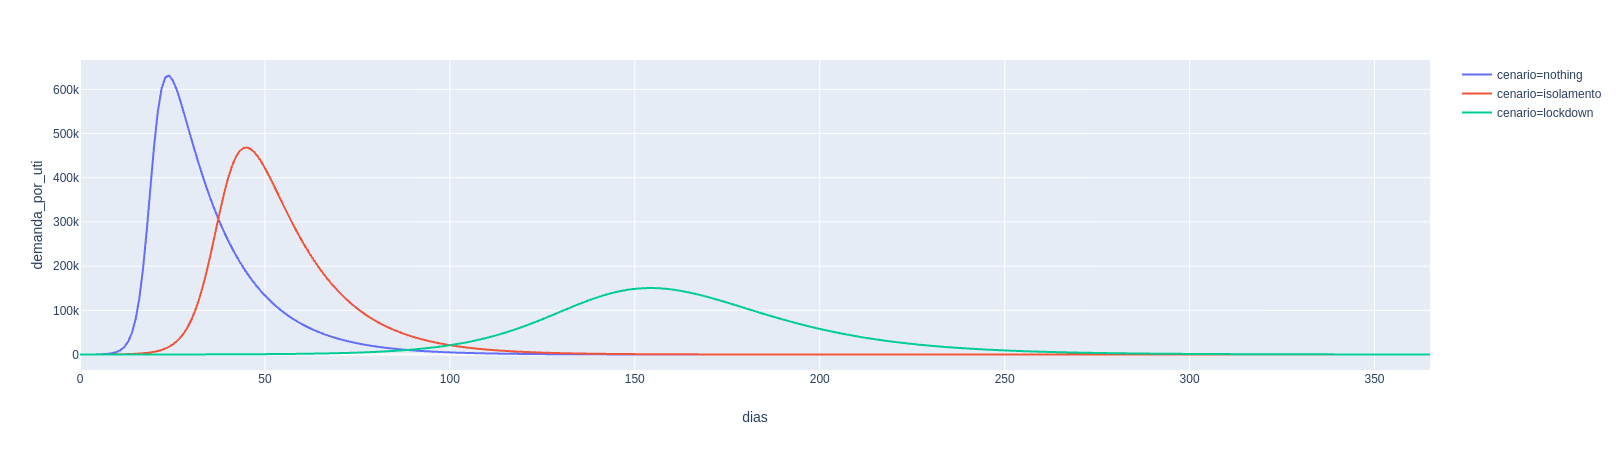

In [77]:
perc = 80

fig = px.line(dd, x='dias',y='demanda_por_uti', color='cenario')
fig

## MODELO

- SIR - https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
- https://colab.research.google.com/drive/1bmR-W2NvQ7gPnldTfei927NtGJUCC1BB#scrollTo=47Er1T5YZBXf

    ro - fixo para cada cidade
    populacao de cada cidade


In [82]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as md

#@title Variables { run: "auto" }
population_in_million = 220 #@param {type:"number"}
percentage_of_immunity =  1#@param {type:"integer"}
number_of_infected =  125#@param {type:"integer"}
number_of_infected_per_person_R0 =  2.5#@param {type:"number"}
days_to_get_better = 15 #@param {type:"number"}
hospital_capacity_in_thousands = 300#@param {type:"number"}
percentage_of_infected_that_needs_hospital = 5#@param {type:"number"}


In [83]:
# Variables

# Total population, N.
N = population_in_million * 1e6

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = number_of_infected, number_of_infected * percentage_of_immunity

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
R_0 = number_of_infected_per_person_R0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

gamma = 1. / days_to_get_better
beta = R_0 * gamma

hospital_capacity = hospital_capacity_in_thousands * 1e3

# A grid of time points (in days)
days = 360
t = np.linspace(0, days, days)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

uti_demand = I * percentage_of_infected_that_needs_hospital / 100  / 1e3

dday = uti_demand[uti_demand > hospital_capacity_in_thousands][0]
dday = np.where(uti_demand == dday)[0][0]



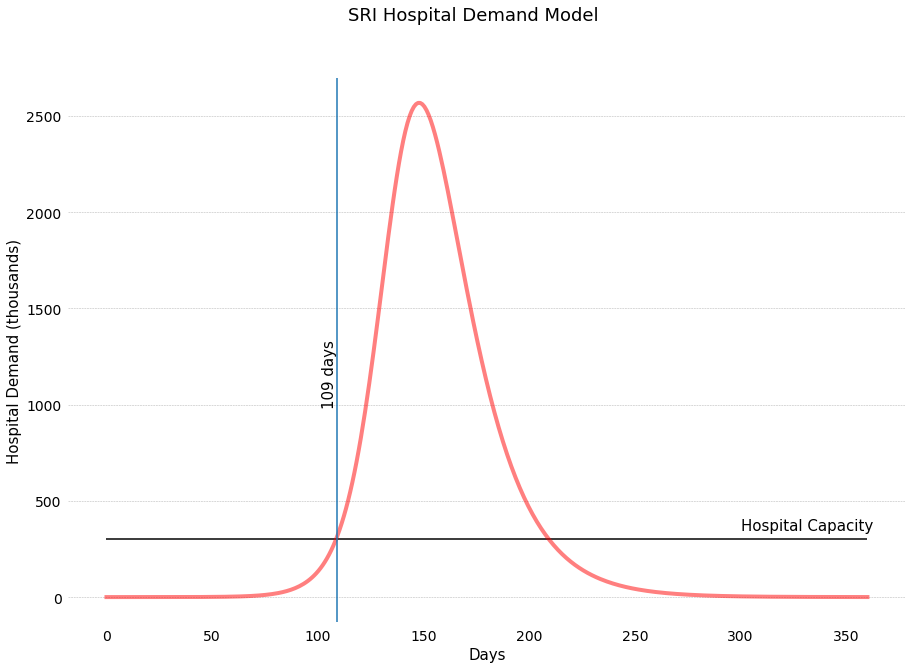

In [84]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
lw = 4
fig = plt.figure(facecolor='w', figsize=(15, 10))
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(t, uti_demand,
            'r', alpha=0.5, lw=lw)

ax.hlines(hospital_capacity_in_thousands, 0, days)
ax.text(300, hospital_capacity_in_thousands + 50, 
        f'Hospital Capacity', rotation=0, fontdict={"size":15})
ax.axvline(dday)
ax.text(dday-7, 1e3 , f'{dday} days', rotation=90, fontdict={"size":15})


ax.tick_params(axis='both', which='both', labelsize=14,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)

ax.set_xlabel('Days', fontdict={"size":15})
ax.set_ylabel('Hospital Demand (thousands)', fontdict={"size":15})

ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.suptitle('SRI Hospital Demand Model', fontsize=18, ha='center')

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()